In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [11]:
# Decision stump used as weak classifier
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None
    def predict(self, X):
        predictions = np.ones(X.shape[0])
        X_column = X[:, self.feature_idx]
        
        # default case 
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1
        return predictions

In [12]:
class Adaboost:
    def __init__(self, n_clf=5):
        self.n_clf = n_clf
        self.clfs = []
    def fit(self, X, y):
        w = np.full(X.shape[0], (1 / X.shape[0]))
        self.clfs = []
        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float("inf")
            for xi in range(X.shape[1]):
                for threshold in np.unique(X[:, xi]):
                    p = 1
                    predictions = np.ones(X.shape[0])
                    predictions[X[:, xi] < threshold] = -1                   
                    error = sum(w[y != predictions])
                    if error > 0.5:
                        error = 1 - error
                        p = -1
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = xi
                        min_error = error
            predictions = clf.predict(X)
            clf.alpha = 0.5 * np.log((1.0 - min_error + 1e-10) / (min_error + 1e-10))
            predictions = clf.predict(X)
            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)
            self.clfs.append(clf)
    def predict(self, X):
        return np.sign(np.sum([clf.alpha * clf.predict(X) for clf in self.clfs], axis=0))

In [13]:
def pre_processing(dataframe):
#     print(dataframe.isna().sum())
    dataframe = dataframe.fillna(df['Age'].mean())
    dataframe = dataframe.drop('PassengerId', axis = 1)
#     print(dataframe['Sex'].unique())
    dataframe['Sex']= dataframe['Sex'].map({'male': 0, 'female': 1}).astype(int)    
    return dataframe

In [14]:
def scale(X):
    new = X - np.mean(X, axis=0)
    return new / np.std(new, axis=0)

In [15]:
def accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred) 
    print(cm)    
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return accuracy

[[97 14]
 [17 51]]


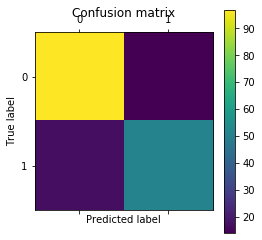

Accuracy: 0.8268156424581006


In [16]:
# Testing
if __name__ == "__main__":
    df=pd.read_csv("data4.csv")
    df = pre_processing (df)
    X = df.drop('Target_class', axis=1)
    y = df['Target_class']
    X = X.to_numpy()
    y = y.to_numpy()
    X = X.astype(int) 
    y = y.astype(int)
    X = scale(X)
    y = np.where(y == 0, -1, 1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2 )
    # Adaboost classification with 5 weak classifiers
    clf = Adaboost(n_clf=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy(y_test, y_pred)
    print("Accuracy:", acc)